In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
train = pd.read_csv('clean_train.csv')
test = pd.read_csv('clean_test.csv')

# Разведочный анализ данных

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [21]:
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [22]:
train.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [23]:
train = train.dropna()
test = test.dropna()

## Пол и доход

Text(0, 0.5, 'Соотношение')

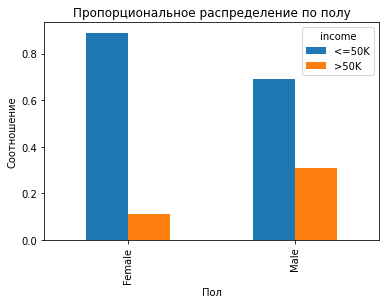

In [24]:
sex = np.round(pd.crosstab(train.sex, train.income).div(pd.crosstab(train.sex, train.income).apply(sum,1),0),2)
sex.sort_values(by = '>50K', inplace = True)
ax = sex.plot(kind ='bar', title = 'Пропорциональное распределение по полу')
ax.set_xlabel('Пол')
ax.set_ylabel('Соотношение')

### Рабочий класс и доход

Text(0, 0.5, 'Соотношение')

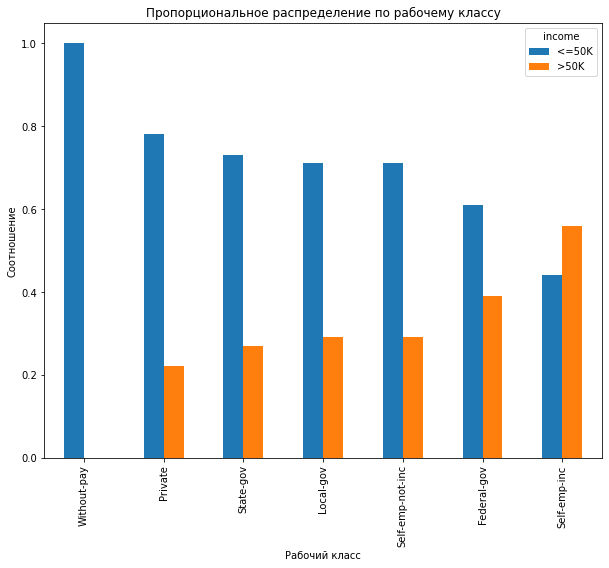

In [25]:
workclass = round(pd.crosstab(train.workclass, train.income).div(pd.crosstab(train.workclass, train.income).apply(sum,1),0),2)
workclass.sort_values(by = '>50K', inplace = True)
ax = workclass.plot(kind ='bar', title = 'Пропорциональное распределение по рабочему классу', figsize = (10,8))
ax.set_xlabel('Рабочий класс')
ax.set_ylabel('Соотношение')

### Образование и доход

In [26]:
education_level = {}
for x,y in train[['education_num','education']].drop_duplicates().itertuples(index=False):
    education_level[y] = x

Text(0, 0.5, 'Соотношение')

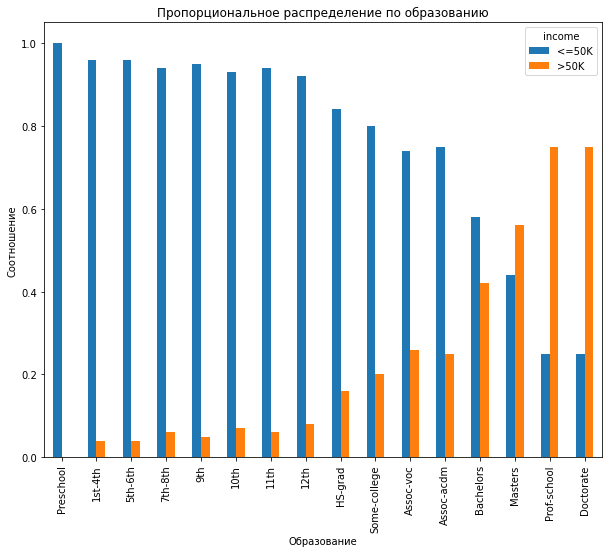

In [27]:
education = np.round(pd.crosstab(train.education, train.income).div(pd.crosstab(train.education, train.income).apply(sum,1),0),2)
education = education.reindex(sorted(education_level, key=education_level.get, reverse=False))

ax = education.plot(kind ='bar', title = 'Пропорциональное распределение по образованию', figsize = (10,8))
ax.set_xlabel('Образование')
ax.set_ylabel('Соотношение')

### Профессия и доход

Text(0, 0.5, 'Соотношение')

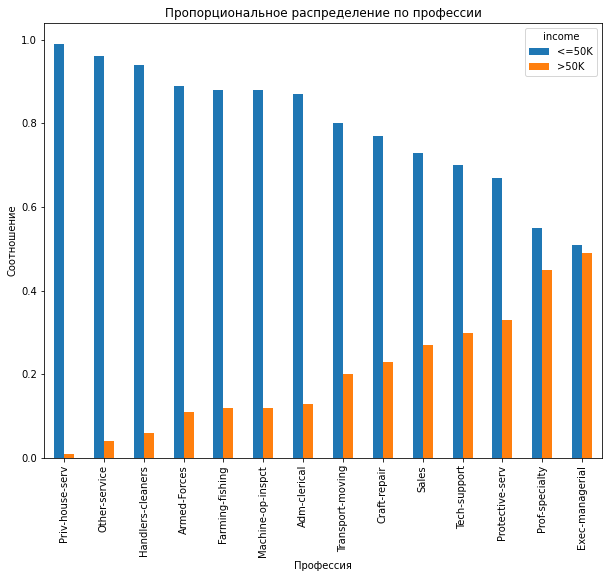

In [28]:
occupation = round(pd.crosstab(train.occupation, train.income).div(pd.crosstab(train.occupation, train.income).apply(sum,1),0),2)
occupation.sort_values(by = '>50K', inplace = True)
ax = occupation.plot(kind ='bar', title = 'Пропорциональное распределение по профессии', figsize = (10,8))
ax.set_xlabel('Профессия')
ax.set_ylabel('Соотношение')

### Раса и доход

Text(0, 0.5, 'Соотношение')

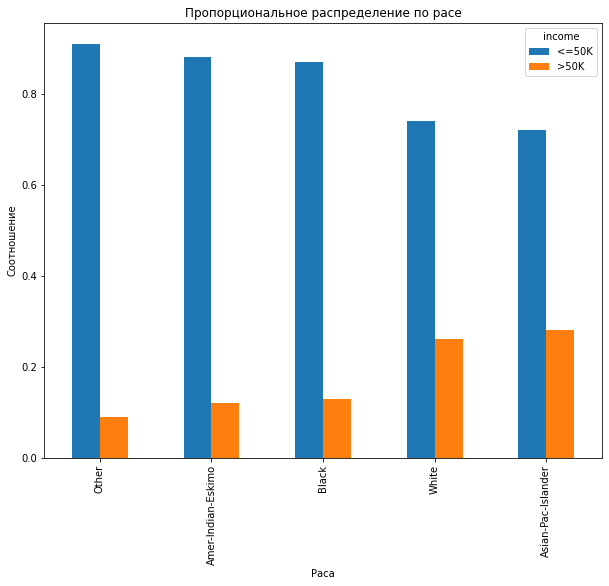

In [29]:
race = round(pd.crosstab(train.race, train.income).div(pd.crosstab(train.race, train.income).apply(sum,1),0),2)
race.sort_values(by = '>50K', inplace = True)
ax = race.plot(kind ='bar', title = 'Пропорциональное распределение по расе', figsize = (10,8))
ax.set_xlabel('Раса')
ax.set_ylabel('Соотношение')

C:\Temp\ipykernel_3708\298195015.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(train.corr(method='pearson'), dtype=np.bool))


Text(0.5, 1.0, 'Тепловая карта корреляции Пирсона')

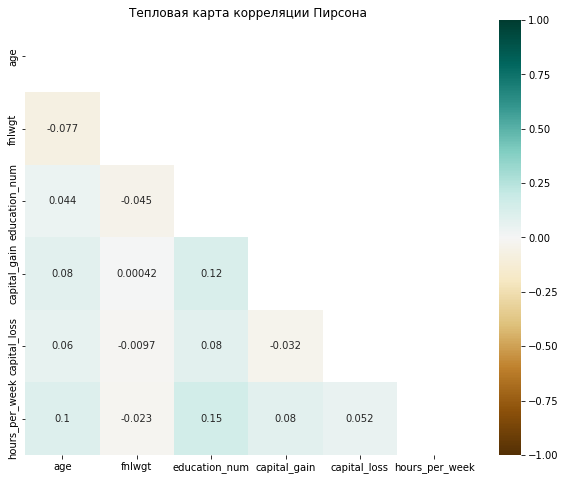

In [30]:
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(train.corr(method='pearson'), dtype=np.bool))
heatmap = sns.heatmap(train.corr(method='pearson'), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Тепловая карта корреляции Пирсона', fontdict={'fontsize':12}, pad=0)

# Кодирование категориальных переменных

In [31]:
data = pd.concat([train, test])
data

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,33.0,Private,245211.0,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K
16276,39.0,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K
16278,38.0,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
16279,44.0,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K


In [32]:
data_non_obj = data.select_dtypes(include=['float64'])
data_non_obj

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39.0,77516.0,13.0,2174.0,0.0,40.0
1,50.0,83311.0,13.0,0.0,0.0,13.0
2,38.0,215646.0,9.0,0.0,0.0,40.0
3,53.0,234721.0,7.0,0.0,0.0,40.0
4,28.0,338409.0,13.0,0.0,0.0,40.0
...,...,...,...,...,...,...
16275,33.0,245211.0,13.0,0.0,0.0,40.0
16276,39.0,215419.0,13.0,0.0,0.0,36.0
16278,38.0,374983.0,13.0,0.0,0.0,50.0
16279,44.0,83891.0,13.0,5455.0,0.0,40.0


In [33]:
data_obj = data.drop('income', axis=1).select_dtypes(include=['object'])
data_obj_dummies = pd.get_dummies(data_obj)
data_obj_dummies

,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
16276,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
16278,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
16279,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [34]:
data_income = pd.DataFrame(data=np.where((data.income == '<=50K'), 0, 1), columns=['income'])
data_income

,income
0,0
1,0
2,0
3,0
4,0
...,...
45217,0
45218,0
45219,0
45220,0


In [35]:
data_processed = pd.concat([data_non_obj.reset_index(drop=True),
                            data_obj_dummies.reset_index(drop=True),
                            data_income.reset_index(drop=True)], axis=1)
data_processed

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,income
0,39.0,77516.0,13.0,2174.0,0.0,40.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50.0,83311.0,13.0,0.0,0.0,13.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38.0,215646.0,9.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,53.0,234721.0,7.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,28.0,338409.0,13.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,33.0,245211.0,13.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
45218,39.0,215419.0,13.0,0.0,0.0,36.0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
45219,38.0,374983.0,13.0,0.0,0.0,50.0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
45220,44.0,83891.0,13.0,5455.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


# Обучение модели

In [39]:
X_train, y_train = data_processed[:30162].drop('income', axis=1), data_processed[:30162].income
X_test, y_test = data_processed[30162:].drop('income', axis=1), data_processed[30162:].income

In [118]:
%%time
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

C:\Users\Egor\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Egor\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:32:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: total: 19.2 s
Wall time: 5.52 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [119]:
%%time
cat_model = CatBoostClassifier()
cat_model.fit(X_train, y_train)

97:	learn: 0.3004097	total: 618ms	remaining: 5.69s
98:	learn: 0.3002490	total: 624ms	remaining: 5.68s
99:	learn: 0.3001475	total: 630ms	remaining: 5.67s
100:	learn: 0.2999951	total: 636ms	remaining: 5.66s
101:	learn: 0.2997022	total: 642ms	remaining: 5.65s
102:	learn: 0.2993801	total: 648ms	remaining: 5.65s
103:	learn: 0.2992828	total: 655ms	remaining: 5.64s
104:	learn: 0.2989589	total: 661ms	remaining: 5.63s
105:	learn: 0.2987853	total: 667ms	remaining: 5.62s
106:	learn: 0.2986290	total: 672ms	remaining: 5.61s
107:	learn: 0.2982873	total: 678ms	remaining: 5.6s
108:	learn: 0.2980191	total: 685ms	remaining: 5.6s
109:	learn: 0.2978562	total: 693ms	remaining: 5.6s
110:	learn: 0.2976245	total: 700ms	remaining: 5.6s
111:	learn: 0.2973241	total: 705ms	remaining: 5.59s
112:	learn: 0.2969892	total: 714ms	remaining: 5.6s
113:	learn: 0.2968091	total: 721ms	remaining: 5.6s
114:	learn: 0.2965262	total: 727ms	remaining: 5.59s
115:	learn: 0.2963845	total: 733ms	remaining: 5.59s
116:	learn: 0.2962505

Learning rate set to 0.044123
0:	learn: 0.6504778	total: 8.62ms	remaining: 8.61s
1:	learn: 0.6113300	total: 16.1ms	remaining: 8.05s
2:	learn: 0.5777369	total: 24.2ms	remaining: 8.03s
3:	learn: 0.5512221	total: 31.4ms	remaining: 7.81s
4:	learn: 0.5222043	total: 37.9ms	remaining: 7.55s
5:	learn: 0.5001929	total: 45.8ms	remaining: 7.58s
6:	learn: 0.4812974	total: 52.2ms	remaining: 7.41s
7:	learn: 0.4643924	total: 59.6ms	remaining: 7.38s
8:	learn: 0.4492519	total: 66.2ms	remaining: 7.29s
9:	learn: 0.4351541	total: 73.2ms	remaining: 7.25s
10:	learn: 0.4217565	total: 80.1ms	remaining: 7.2s
11:	learn: 0.4124189	total: 86.5ms	remaining: 7.12s
12:	learn: 0.4039131	total: 93.9ms	remaining: 7.13s
13:	learn: 0.3957821	total: 101ms	remaining: 7.11s
14:	learn: 0.3889929	total: 108ms	remaining: 7.08s
15:	learn: 0.3834583	total: 114ms	remaining: 7.01s
16:	learn: 0.3781800	total: 121ms	remaining: 6.98s
17:	learn: 0.3725033	total: 128ms	remaining: 7s
18:	learn: 0.3678313	total: 136ms	remaining: 7s
19:	l

In [40]:
%%time
lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(X_train, y_train)

CPU times: total: 1.08 s
Wall time: 375 ms


LGBMClassifier()

In [121]:
%%time
skl_model = GradientBoostingClassifier()
skl_model.fit(X_train, y_train)

CPU times: total: 9.44 s
Wall time: 9.1 s


GradientBoostingClassifier()

In [122]:
xgb_pred = xgb_model.predict(X_test)

C:\Users\Egor\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [123]:
cat_pred = cat_model.predict(X_test)

In [44]:
lgbm_pred = lgbm_model.predict(X_test)


0.8693891102257636

In [125]:
skl_pred = skl_model.predict(X_test)

In [42]:
print(accuracy_score(y_test, xgb_pred), accuracy_score(y_test, cat_pred),accuracy_score(y_test, lgbm_pred), accuracy_score(y_test, skl_pred))

NameError: name 'xgb_pred' is not defined

## Поиск гиперпараметров

In [ ]:
%time
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_train, y=y_train)
param_grid = {
    'num_leaves': (10, 22, 31, 40),
    'learning_rate': (0, 0.01, 0.05, 0.1),
    'colsample_bytree': (0.7, 0.8, 0.9, 1)
}

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc')

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
lgb_model = gsearch.fit(X=X_train, y=y_train)

print(lgb_model.best_params_, lgb_model.best_score_)

# Окончательная модель

In [ ]:
model = lgb.LGBMClassifier(colsample_bytree=0.7, num_leaves=22, learning_rate=0.1, n_estimators=100)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(round(accuracy_score(y_test, pred), 5))